# Part 1: Gathering Data


In [112]:
from pathlib import Path
import time

import os
import requests
import pandas as pd


def fetch_and_cache_gdrive(gdrive_id, file, data_dir="data", force=False):
    """
    Download and cache a url and return the file object.

    data_url: the web address to download
    file: the file in which to save the results.
    data_dir: (default="data") the location to save the data
    force: if true the file is always re-downloaded

    return: The pathlib.Path object representing the file.
    """

    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok = True)
    file_path = data_dir / Path(file)
    # If the file already exists and we want to force a download then
    # delete the file first so that the creation date is correct.
    if force and file_path.exists():
        file_path.unlink()
    if force or not file_path.exists():
        print('Downloading...', end=' ')
        download_file_from_google_drive(gdrive_id, file_path)
        print('Done!')
        last_modified_time = time.ctime(file_path.stat().st_mtime)
    else:
        last_modified_time = time.ctime(file_path.stat().st_mtime)
        print("Using cached version that was downloaded (UTC):", last_modified_time)
    return file_path



# https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)

    needs_confirm = needs_confirmation(response)

    if needs_confirm:
        params = { 'id' : id, 'confirm' : 't' ,}
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

def needs_confirmation(response):

    return response.headers["Content-Type"] == 'text/html; charset=utf-8'

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


In [113]:
# download required datasets

file_dict = {
    "aqs_sites.csv": "1fMfkw-NJ03VrQxYpDjM_4T6VDaWhvegi",
    "greenhouse_gas_emmitter_facilities.csv": "1yjTRv1OrsdWk-xNW4ZbFYB7_8Tt_x_fV",
    "greenhouse_gas_emmiter_gas_types.csv":"1akEokx_wqsgYqGNnNJsgebA6DDGHJLR2",
    "2020_daily_global_weather.csv":"15pjzsCiIE0uL69a4tZYgXoog8TKjIJNJ",
    "daily_wind_2020.csv": "18MqsjkN0EYPuLb0iR0U9sZYmNVCdd94h",
    "daily_temperature_2020.csv": "1Q62JlGtc65L2eU9FfQZcP9UyMCdcem1T",
    "traffic_volumes.csv": "1sZyjZSWz1xEoB26u_OrhKokZYhTIJRMD",
    "county_aqi_2020_daily.csv": "1uNH90XRceOfb16ctuUsYXVIEDeR2yaeC"
    }

for k, v in file_dict.items():
    path = f"./datasets/{k}"
    if not os.path.exists(path):
        download_file_from_google_drive(v,path)



## Creating Dataframes

In [114]:
aqs_site_df = pd.read_csv(f"./datasets/aqs_sites.csv")
gh_gas_facil_df = pd.read_csv(f"./datasets/greenhouse_gas_emmitter_facilities.csv")
gh_gas_type_df = pd.read_csv(f"./datasets/greenhouse_gas_emmiter_gas_types.csv")
weather_2020_df = pd.read_csv(f"./datasets/2020_daily_global_weather.csv")
wind_2020_df = pd.read_csv(f"./datasets/daily_wind_2020.csv")
temp_2020_df = pd.read_csv(f"./datasets/daily_temperature_2020.csv")
traffic_volumes_df = pd.read_csv(f"./datasets/traffic_volumes.csv")
aqi_2020 = pd.read_csv(f"./datasets/county_aqi_2020_daily.csv")

/var/folders/3b/8_5j3wnd7t9crcx504qmyfvh0000gn/T/ipykernel_65181/2721585776.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  gh_gas_facil_df = pd.read_csv(f"./datasets/greenhouse_gas_emmitter_facilities.csv")


### aqs site data

In [115]:
print(aqs_site_df.columns)
display(aqs_site_df.sample(10))

Index(['State Code', 'County Code', 'Site Number', 'Latitude', 'Longitude',
       'Datum', 'Elevation', 'Land Use', 'Location Setting',
       'Site Established Date', 'Site Closed Date', 'Met Site State Code',
       'Met Site County Code', 'Met Site Site Number', 'Met Site Type',
       'Met Site Distance', 'Met Site Direction', 'GMT Offset',
       'Owning Agency', 'Local Site Name', 'Address', 'Zip Code', 'State Name',
       'County Name', 'City Name', 'CBSA Name', 'Tribe Name',
       'Extraction Date'],
      dtype='object')


,State Code,County Code,Site Number,Latitude,Longitude,Datum,Elevation,Land Use,Location Setting,Site Established Date,...,Owning Agency,Local Site Name,Address,Zip Code,State Name,County Name,City Name,CBSA Name,Tribe Name,Extraction Date
444,02,90,23,64.841790,-147.753258,WGS84,136.0,INDUSTRIAL,URBAN AND CENTER CITY,2002-04-01,...,US EPA - Region 10,NaN,"202 WIEN ST, NATIONAL GUARD ARMORY",NaN,Alaska,Fairbanks North Star,Fairbanks,"Fairbanks, AK",NaN,2021-05-18
13868,39,81,4,40.372800,-80.610619,WGS84,210.0,INDUSTRIAL,URBAN AND CENTER CITY,1969-01-01,...,North Ohio Valley Air Authority,NaN,GARFIELD SCHOOL 936 N 5TH ST,43952.0,Ohio,Jefferson,Steubenville,"Weirton-Steubenville, WV-OH",NaN,2021-05-18
8576,26,99,1001,42.526396,-82.939857,WGS84,187.0,COMMERCIAL,SUBURBAN,1971-01-01,...,"Michigan Dept Of Environment, Great Lakes, and...",NaN,31275 EVENINGSIDE FRASER,48026.0,Michigan,Macomb,Fraser,"Detroit-Warren-Dearborn, MI",NaN,2021-05-18
4322,16,79,21,47.534644,-116.167944,WGS84,701.0,INDUSTRIAL,SUBURBAN,1973-01-01,...,Idaho Department Of Health And Welfare-Environ...,NaN,"SIVERKING SCHOOL/GOV GULCH, SMELTERVILLE",NaN,Idaho,Shoshone,Not in a city,NaN,NaN,2021-05-18
1298,06,29,2019,35.376953,-119.043889,NAD83,87.0,INDUSTRIAL,URBAN AND CENTER CITY,2019-01-01,...,San Joaquin Valley Unified Air Pollution Contr...,Bakersfield-Westwind,2001 Westwind Drive,93301.0,California,Kern,Bakersfield,"Bakersfield, CA",NaN,2021-05-18
6241,19,181,1,41.363513,-93.561547,WGS84,0.0,NaN,NaN,1970-01-01,...,Iowa Department Of Natural Resources,NaN,BOX 235 INDIANOLA,50125.0,Iowa,Warren,Indianola,"Des Moines-West Des Moines, IA",NaN,2021-05-18
17117,47,189,2,36.289218,-86.386382,WGS84,158.0,AGRICULTURAL,RURAL,1973-01-01,...,Tennessee Valley Authority,NaN,2 MILES SSE OF GALLATIN STEAM PLANT,NaN,Tennessee,Wilson,Not in a city,"Nashville-Davidson--Murfreesboro--Franklin, TN",NaN,2021-05-18
2347,08,67,6,37.269169,-107.881178,WGS84,2002.0,RESIDENTIAL,URBAN AND CENTER CITY,1992-06-01,...,Colorado Department of Public Health And Envir...,NaN,405 3RD AVE,81301.0,Colorado,La Plata,Durango,"Durango, CO",NaN,2021-05-18
9226,27,71,7,48.602994,-93.404316,WGS84,347.0,COMMERCIAL,URBAN AND CENTER CITY,1976-07-15,...,"Minnesota Pollution Control Agency, Division O...",NaN,314 3RD STREET,NaN,Minnesota,Koochiching,International Falls,NaN,NaN,2021-05-18
3803,12,127,2,28.938882,-81.316222,WGS84,25.0,INDUSTRIAL,RURAL,1973-01-01,...,Florida Department of Environmental Protection...,NaN,SPRINGS ROAD 1 MILE WEST OF ORANGE CITY,32763.0,Florida,Volusia,Not in a City,"Deltona-Daytona Beach-Ormond Beach, FL",NaN,2021-05-18


### gh gas facility data

In [5]:
print(gh_gas_facil_df.columns)
display(gh_gas_facil_df.sample(10))

Index(['V_GHG_EMITTER_FACILITIES.ADDRESS1',
       'V_GHG_EMITTER_FACILITIES.ADDRESS2',
       'V_GHG_EMITTER_FACILITIES.CEMS_USED', 'V_GHG_EMITTER_FACILITIES.CITY',
       'V_GHG_EMITTER_FACILITIES.COUNTY',
       'V_GHG_EMITTER_FACILITIES.COUNTY_FIPS',
       'V_GHG_EMITTER_FACILITIES.FACILITY_ID',
       'V_GHG_EMITTER_FACILITIES.LATITUDE',
       'V_GHG_EMITTER_FACILITIES.LONGITUDE',
       'V_GHG_EMITTER_FACILITIES.PRIMARY_NAICS_CODE',
       'V_GHG_EMITTER_FACILITIES.STATE', 'V_GHG_EMITTER_FACILITIES.STATE_NAME',
       'V_GHG_EMITTER_FACILITIES.YEAR', 'V_GHG_EMITTER_FACILITIES.ZIP',
       'V_GHG_EMITTER_FACILITIES.FACILITY_NAME',
       'V_GHG_EMITTER_FACILITIES.SECONDARY_NAICS_CODE',
       'V_GHG_EMITTER_FACILITIES.ADDITIONAL_NAICS_CODES',
       'V_GHG_EMITTER_FACILITIES.COGENERATION_UNIT_EMISS_IND',
       'V_GHG_EMITTER_FACILITIES.EPA_VERIFIED',
       'V_GHG_EMITTER_FACILITIES.PARENT_COMPANY',
       'V_GHG_EMITTER_FACILITIES.PLANT_CODE_INDICATOR'],
      dtype='object')


,V_GHG_EMITTER_FACILITIES.ADDRESS1,V_GHG_EMITTER_FACILITIES.ADDRESS2,V_GHG_EMITTER_FACILITIES.CEMS_USED,V_GHG_EMITTER_FACILITIES.CITY,V_GHG_EMITTER_FACILITIES.COUNTY,V_GHG_EMITTER_FACILITIES.COUNTY_FIPS,V_GHG_EMITTER_FACILITIES.FACILITY_ID,V_GHG_EMITTER_FACILITIES.LATITUDE,V_GHG_EMITTER_FACILITIES.LONGITUDE,V_GHG_EMITTER_FACILITIES.PRIMARY_NAICS_CODE,...,V_GHG_EMITTER_FACILITIES.STATE_NAME,V_GHG_EMITTER_FACILITIES.YEAR,V_GHG_EMITTER_FACILITIES.ZIP,V_GHG_EMITTER_FACILITIES.FACILITY_NAME,V_GHG_EMITTER_FACILITIES.SECONDARY_NAICS_CODE,V_GHG_EMITTER_FACILITIES.ADDITIONAL_NAICS_CODES,V_GHG_EMITTER_FACILITIES.COGENERATION_UNIT_EMISS_IND,V_GHG_EMITTER_FACILITIES.EPA_VERIFIED,V_GHG_EMITTER_FACILITIES.PARENT_COMPANY,V_GHG_EMITTER_FACILITIES.PLANT_CODE_INDICATOR
33322,949 COUNTY ROAD 935,NaN,NaN,NACOGDOCHES,NACOGDOCHES,48347.0,1002672.0,31.789875,-94.759040,211111.0,...,TEXAS,2011.0,75964.0,Trawick Central Station,NaN,NaN,Y,NaN,EXXON MOBIL CORPORATION (100%),NaN
24071,1400 HIGHWAY 101 SOUTH,NaN,NaN,GREER,GREENVILLE,45045.0,1005880.0,34.904943,-82.178888,336111.0,...,SOUTH CAROLINA,2010.0,29651.0,BMW MANUFACTURING CORPORATION,NaN,423110,N,NaN,S.B. ACQUISITIONS INC. (100%),NaN
24388,2800 FM 519 E,NaN,NaN,TEXAS CITY,GALVESTON,48167.0,1003429.0,29.359644,-94.931297,325199.0,...,TEXAS,2010.0,77592.0,INEOS NOVA LLC Texas City Site,NaN,NaN,N,NaN,NaN,NaN
2773,3545 W FARM RD 34,NaN,NaN,WILLARD,GREENE COUNTY,29077.0,1002906.0,37.377418,-93.342656,562212.0,...,MISSOURI,2019.0,65781.0,SPRINGFIELD SANITARY LANDFILL,NaN,NaN,N,NaN,SPRINGFIELD MISSOURI (100%),N
39323,601 Madison Road,NaN,NaN,East Saint Louis,ST. CLAIR COUNTY,17163.0,1008269.0,38.658596,-90.121452,562212.0,...,ILLINOIS,2015.0,62201.0,Milam Recycling and Disposal Facility,NaN,NaN,N,NaN,WASTE MANAGEMENT INC (100%),Y
20440,913 BOWMAN STREET,NaN,NaN,MANSFIELD,RICHLAND COUNTY,39139.0,1006530.0,40.785130,-82.523840,331110.0,...,OHIO,2019.0,44903.0,AK STEEL CORP MANSFIELD WORKS,NaN,NaN,N,NaN,AK STEEL HOLDING CORP (100%),N
69668,35.7263 -98.5038,NaN,NaN,Greenfield,BLAINE COUNTY,40011.0,1010833.0,35.732414,-98.374572,211111.0,...,OKLAHOMA,2013.0,73043.0,Pearl Compressor Station,NaN,NaN,N,Y,DEVON GAS SERVICES LP (100%),NaN
57880,4902 PEABODY ROAD,NaN,NaN,COLUMBIA,Boone,29019.0,1000820.0,39.018300,-92.263300,221112.0,...,MISSOURI,2012.0,65202.0,Columbia Energy Center (MO),NaN,NaN,N,NaN,CITY OF COLUMBIA MISSOURI (100%),NaN
66797,13727 NOEL ROAD SUITE 1200,NaN,NaN,DALLAS,DALLAS COUNTY,48113.0,1009327.0,32.934760,-96.818010,211111.0,...,TEXAS,2015.0,75240.0,MERIT ENERGY CO LLC 420 FORT WORTH SYNCLINE,NaN,NaN,N,NaN,MERIT ENERGY CO LLC (100%),N
16115,100 ADDINGTON RD,NaN,NaN,ASHLAND,GREENUP COUNTY,21089.0,1004483.0,38.396570,-82.808560,562212.0,...,KENTUCKY,2018.0,41102.0,GREEN VALLEY LANDFILL,NaN,NaN,N,NaN,REPUBLIC SERVICES INC (100%),N


### gh gas type data

In [6]:
print(gh_gas_type_df.columns)
display(gh_gas_type_df.sample(10))

Index(['V_GHG_EMITTER_GAS.ADDRESS1', 'V_GHG_EMITTER_GAS.ADDRESS2',
       'V_GHG_EMITTER_GAS.CITY', 'V_GHG_EMITTER_GAS.CO2E_EMISSION',
       'V_GHG_EMITTER_GAS.COUNTY', 'V_GHG_EMITTER_GAS.FACILITY_ID',
       'V_GHG_EMITTER_GAS.GAS_CODE', 'V_GHG_EMITTER_GAS.GAS_NAME',
       'V_GHG_EMITTER_GAS.LATITUDE', 'V_GHG_EMITTER_GAS.LONGITUDE',
       'V_GHG_EMITTER_GAS.STATE', 'V_GHG_EMITTER_GAS.STATE_NAME',
       'V_GHG_EMITTER_GAS.YEAR', 'V_GHG_EMITTER_GAS.ZIP',
       'V_GHG_EMITTER_GAS.FACILITY_NAME', 'V_GHG_EMITTER_GAS.COUNTY_FIPS'],
      dtype='object')


,V_GHG_EMITTER_GAS.ADDRESS1,V_GHG_EMITTER_GAS.ADDRESS2,V_GHG_EMITTER_GAS.CITY,V_GHG_EMITTER_GAS.CO2E_EMISSION,V_GHG_EMITTER_GAS.COUNTY,V_GHG_EMITTER_GAS.FACILITY_ID,V_GHG_EMITTER_GAS.GAS_CODE,V_GHG_EMITTER_GAS.GAS_NAME,V_GHG_EMITTER_GAS.LATITUDE,V_GHG_EMITTER_GAS.LONGITUDE,V_GHG_EMITTER_GAS.STATE,V_GHG_EMITTER_GAS.STATE_NAME,V_GHG_EMITTER_GAS.YEAR,V_GHG_EMITTER_GAS.ZIP,V_GHG_EMITTER_GAS.FACILITY_NAME,V_GHG_EMITTER_GAS.COUNTY_FIPS
173867,2237 HATCHER HILL RD,NaN,BACONTON,35336.600000,Mitchell,1001409,CO2,Carbon Dioxide,31.386900,-84.081900,GA,GEORGIA,2018,31716,Baconton,13205.0
105940,NaN,NaN,LA GRANGE,73.904000,FAYETTE COUNTY,1006255,N2O,Nitrous Oxide,30.006000,-96.888500,TX,TEXAS,2014,78945,LAGRANGE PLANT,48149.0
153473,14400 N. Rivergate Blvd,NaN,Portland,49.750000,MULTNOMAH COUNTY,1001840,CH4,Methane,45.628490,-122.781250,OR,OREGON,2013,97203,Evraz Oregon Steel,41051.0
89232,NaN,NaN,Eunice,9263.250000,LEA COUNTY,1007441,CH4,Methane,32.426150,-103.148564,NM,NEW MEXICO,2017,88231,Targa Midstream Services LLC - Eunice Gas Proc...,35025.0
57066,9995 STATE ROAD 37 SOUTH,NaN,MULBERRY,152.617234,Polk,1001100,N2O,Nitrous Oxide,27.728600,-81.989700,FL,FLORIDA,2016,33860,Polk,12105.0
148078,704 FACTORY STREET,NaN,WILKESBORO,25050.200000,WILKES COUNTY,1000015,CO2,Carbon Dioxide,36.143889,-81.163333,NC,NORTH CAROLINA,2011,28697,TYSON FARMS INC.,37193.0
17648,800 LaSalle Ave Floor 14 PO Box 59038,NaN,Minneapolis,96643.500000,HENNEPIN COUNTY,1004086,CH4,Methane,44.976190,-93.274820,MN,MINNESOTA,2011,55459,CenterPoint Energy Minnesota Gas,27053.0
131637,NaN,NaN,BORGER,8900.000000,HUTCHINSON COUNTY,1006301,CH4,Methane,35.703060,-101.363050,TX,TEXAS,2014,79008,BORGER REFINERY,48233.0
182133,755 LIME ROAD,NaN,WOODVILLE,999.500000,SANDUSKY COUNTY,1004097,CH4,Methane,41.462857,-83.367460,OH,OHIO,2010,43469,MARTIN MARIETTA MAGNESIA SPECIALTIES LLC,39143.0
115447,1001 13TH AVE. E.,NaN,BRADENTON,2190.800000,MANATEE COUNTY,1004365,BIOCO2,Biogenic CO2,27.487024,-82.551166,FL,FLORIDA,2018,34208,TROPICANA MANUFACTURING CO INC,12081.0


### weather 2020 data 

In [7]:
print(weather_2020_df.columns)
display(weather_2020_df.sample(10))

Index(['Unnamed: 0', 'Station', 'Date', 'TAVG', 'Latitude', 'Longitude',
       'Elevation', 'PRCP'],
      dtype='object')


,Unnamed: 0,Station,Date,TAVG,Latitude,Longitude,Elevation,PRCP
380595,380595,CA007040444,2020-04-14,18.0,49.1333,-68.2000,22.0,7.0
896865,896865,USS0012K02S,2020-09-04,219.0,39.3500,-112.3300,2392.7,0.0
88318,88318,CA005031320,2020-01-25,-68.0,49.6167,-95.2000,327.0,0.0
386935,386935,USW00094224,2020-04-15,103.0,46.1569,-123.8825,2.7,18.0
630936,630936,USS0020A07S,2020-06-22,114.0,48.5300,-120.9900,1316.7,0.0
120083,120083,USS0011G33S,2020-02-02,-3.0,42.4100,-111.1700,2112.3,25.0
305819,305819,RSM00022619,2020-03-24,-1.0,63.2700,33.4200,130.0,0.0
462124,462124,USS0011E38S,2020-05-06,30.0,44.9500,-111.3600,2392.7,25.0
576100,576100,USS0005L11S,2020-06-07,110.0,38.8800,-105.0700,3493.0,0.0
148763,148763,RSM00023205,2020-02-10,-18.0,67.6331,53.0331,5.0,8.0


### wind 2020 data

In [8]:
print(wind_2020_df.columns)
display(wind_2020_df.sample(10))

Index(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Sample Duration',
       'Pollutant Standard', 'Date Local', 'Units of Measure', 'Event Type',
       'Observation Count', 'Observation Percent', 'Arithmetic Mean',
       '1st Max Value', '1st Max Hour', 'AQI', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'State Name', 'County Name', 'City Name',
       'CBSA Name', 'Date of Last Change'],
      dtype='object')


,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,...,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
35358,6,11,1002,61103,1,39.189190,-121.998870,NAD83,Wind Speed - Resultant,1 HOUR,...,NaN,66,Instrumental - RM Young Ultrasonic Anemometer ...,Colusa-Sunrise Blvd,"100 SUNRISE BLVD., COLUSA",California,Colusa,Colusa,NaN,2021-03-23
390945,48,141,1021,61104,1,31.862470,-106.547300,WGS84,Wind Direction - Resultant,1 HOUR,...,NaN,20,INSTRUMENTAL - VECTOR SUMMATION,Ojo De Agua,6767 Ojo De Agua,Texas,El Paso,El Paso,"El Paso, TX",2021-03-19
364258,48,29,32,61103,1,29.515090,-98.620166,WGS84,Wind Speed - Resultant,1 HOUR,...,NaN,20,INSTRUMENTAL - VECTOR SUMMATION,San Antonio Northwest,6655 Bluebird Lane,Texas,Bexar,San Antonio,"San Antonio-New Braunfels, TX",2021-03-29
404929,48,201,1052,61103,1,29.814530,-95.387690,WGS84,Wind Speed - Resultant,1 HOUR,...,NaN,20,INSTRUMENTAL - VECTOR SUMMATION,Houston North Loop,822 North Loop,Texas,Harris,Houston,"Houston-The Woodlands-Sugar Land, TX",2021-03-30
472207,56,13,4,61104,1,43.024210,-108.363700,NAD83,Wind Direction - Resultant,1 HOUR,...,NaN,20,INSTRUMENTAL - VECTOR SUMMATION,Riverton Mobile,NaN,Wyoming,Fremont,Riverton,"Riverton, WY",2021-03-08
125598,6,103,4,61103,1,40.262072,-122.092766,WGS84,Wind Speed - Resultant,1 HOUR,...,NaN,66,Instrumental - RM Young Ultrasonic Anemometer ...,Tuscan Butte (seasonal),OLD FIRE LOOKOUT ATOP TUSCAN BUTTE,California,Tehama,Not in a city,"Red Bluff, CA",2021-03-08
344039,41,37,1,61104,1,42.189215,-120.353969,WGS84,Wind Direction - Resultant,1 HOUR,...,NaN,20,INSTRUMENTAL - VECTOR SUMMATION,"Lakeview, CENTER & M ST. (LCM)","LCM/CENTER & M ST, LAKEVIEW, OR",Oregon,Lake,Lakeview,NaN,2021-03-30
277673,29,71,9003,61104,1,38.548600,-90.837250,NAD83,Wind Direction - Resultant,1 HOUR,...,NaN,127,Instrumental - ACOUSTIC SOUNDER,"Labadie ""Plant Site""","""Plant Site"", ~1.5 km south of the Labadie Ene...",Missouri,Franklin,Not in a city,"St. Louis, MO-IL",2021-03-16
74860,6,39,4,61103,1,36.867125,-120.010158,NAD83,Wind Speed - Resultant,1 HOUR,...,NaN,20,INSTRUMENTAL - VECTOR SUMMATION,Madera-Pump Yard,RD. 29 1/2 NO. OF AVE 8 MADERA COUNTY,California,Madera,Madera,"Madera, CA",2021-04-28
468540,55,89,8,61103,1,43.343000,-87.920000,NAD83,Wind Speed - Resultant,1 HOUR,...,NaN,20,INSTRUMENTAL - VECTOR SUMMATION,GRAFTON,"N. Port Washington Rd., East side of HWY32 AND...",Wisconsin,Ozaukee,Not in a city,"Milwaukee-Waukesha-West Allis, WI",2021-03-04


### temp 2020 data

In [9]:
print(temp_2020_df.columns)
display(temp_2020_df.sample(10))

Index(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Sample Duration',
       'Pollutant Standard', 'Date Local', 'Units of Measure', 'Event Type',
       'Observation Count', 'Observation Percent', 'Arithmetic Mean',
       '1st Max Value', '1st Max Hour', 'AQI', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'State Name', 'County Name', 'City Name',
       'CBSA Name', 'Date of Last Change'],
      dtype='object')


,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,...,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
105362,21,185,4,62101,1,38.400200,-85.444280,WGS84,Outdoor Temperature,1 HOUR,...,NaN,40,INSTRUMENTAL - ELECTRONIC OR MACHINE AVG.,BUCKNER,"KYTC MAINTENANCE FACILITY, 1601 SOUTH HWY 393",Kentucky,Oldham,Buckner,"Louisville/Jefferson County, KY-IN",2021-03-31
288671,56,41,101,62101,2,41.373097,-111.042376,WGS84,Outdoor Temperature,1 HOUR,...,NaN,40,INSTRUMENTAL - ELECTRONIC OR MACHINE AVG.,Murphy Ridge,Murphy Ridge LOCATED NEAR WYOMING UTAH BORDER,Wyoming,Uinta,Not in a city,"Evanston, WY",2021-04-29
98174,19,137,2,62101,1,40.969112,-95.044951,NAD83,Outdoor Temperature,1 HOUR,...,NaN,40,INSTRUMENTAL - ELECTRONIC OR MACHINE AVG.,VIKING LAKE STATE PARK,2780 VIKING LAKE ROAD,Iowa,Montgomery,Not in a city,NaN,2021-01-12
147,1,53,1000,62101,1,31.092100,-87.543500,NAD83,Outdoor Temperature,1 HOUR,...,NaN,60,Instrumental - Vaisala 435C RH/AT Sensor,PCI MET1,Jack Springs Rd,Alabama,Escambia,Not in a city,NaN,2021-03-25
41816,6,69,2,62101,1,36.843425,-121.362100,NAD83,Outdoor Temperature,1 HOUR,...,NaN,50,Instrumental - Visual average,Hollister,1979 Fairview Rd,California,San Benito,Hollister,"San Jose-Sunnyvale-Santa Clara, CA",2021-04-20
241465,49,47,2003,62101,1,40.056710,-109.688108,WGS84,Outdoor Temperature,1 HOUR,...,NaN,41,INSTRUMENTAL - ELEC. OR MACH. AVG. LEVEL 1,NaN,2 miles south of Ouray and south of the White ...,Utah,Uintah,Not in a city,"Vernal, UT",2021-03-24
257838,55,133,27,62101,1,43.020075,-88.215070,WGS84,Outdoor Temperature,1 HOUR,...,NaN,40,INSTRUMENTAL - ELECTRONIC OR MACHINE AVG.,WAUKESHA - CLEVELAND AVE,1310 CLEVELAND AVE,Wisconsin,Waukesha,Waukesha,"Milwaukee-Waukesha-West Allis, WI",2021-03-05
285885,56,37,2851,62101,1,41.754697,-108.800341,WGS84,Outdoor Temperature,1 HOUR,...,NaN,40,INSTRUMENTAL - ELECTRONIC OR MACHINE AVG.,Jim Bridger Meteorological Station,Jim Bridger Met Site,Wyoming,Sweetwater,Not in a city,"Rock Springs, WY",2021-03-03
40728,6,67,10,62101,2,38.568440,-121.493110,NAD83,Outdoor Temperature,1 HOUR,...,NaN,59,Instrumental - Vaisala HMP 155,Sacramento-1309 T Street,"1309 T ST., SACRAMENTO, CA. 95814",California,Sacramento,Sacramento,"Sacramento--Roseville--Arden-Arcade, CA",2021-03-23
120253,26,27,3,62101,1,41.895570,-86.001629,WGS84,Outdoor Temperature,1 HOUR,...,NaN,40,INSTRUMENTAL - ELECTRONIC OR MACHINE AVG.,"Cassopolis ROSS BEATTY HIGH SCHOOL, 22721 DIAM...",22721 DIAMOND COVE ST (CASSOPOLIS),Michigan,Cass,Cassopolis,"South Bend-Mishawaka, IN-MI",2021-03-01


### traffic volumes data

In [10]:
print(traffic_volumes_df.columns)
display(traffic_volumes_df.sample(10))

Index(['OBJECTID_1', 'OBJECTID', 'District', 'Route', 'Rte_SFX', 'County',
       'PM_PFX', 'Postmile', 'PM_SFX', 'Descriptn', 'Back_pk_h', 'Back_pk_m',
       'Back_AADT', 'Ahead_pk_h', 'Ahead_pk_m', 'Ahead_AADT', 'Lon_S_or_W',
       'Lat_S_or_W', 'Lon_N_or_E', 'Lat_N_or_E'],
      dtype='object')


,OBJECTID_1,OBJECTID,District,Route,Rte_SFX,County,PM_PFX,Postmile,PM_SFX,Descriptn,Back_pk_h,Back_pk_m,Back_AADT,Ahead_pk_h,Ahead_pk_m,Ahead_AADT,Lon_S_or_W,Lat_S_or_W,Lon_N_or_E,Lat_N_or_E
4228,4229,4229,7,23,,VEN,R,5.064,,"THOUSAND OAKS, JANSS ROAD",10000,119000,116000,9900,114000,111000,-118.8573498,34.19988699,-118.8570059,34.19981402
5434,5435,5435,8,215,,SBD,,14.091,,PALM AVENUE,5600,74000,71000,5600,74000,71000,-117.3612278,34.19084705,-117.3611315,34.19102024
3229,3230,3230,6,5,,KER,,38.793,,JCT. RTE. 119,5500,45000,38500,5600,47000,39500,-119.2248215,35.26709772,-119.2243015,35.26710089
4179,4180,4180,7,10,,LA,,46.405,,"POMONA, TOWNE AVENUE",18800,284000,273000,18300,290000,278000,-117.7417237,34.07826782,-117.7418236,34.0780526
3807,3808,3808,6,190,,TUL,,47.980,,CAMP NELSON ROAD,140,760,680,70,420,340,-118.6166279,36.13955918,-118.6166279,36.13955918
4888,4889,4889,8,10,,SBD,,25.261,,WATERMAN AVENUE,15700,235000,230000,13900,209000,205000,-117.2789834,34.06438803,-117.2789725,34.06412278
6912,6913,6913,12,22,,ORA,R,0.660,,JCT. RTE. 405,11200,148000,147000,15600,150000,147000,-118.086086,33.77482305,-118.0861026,33.77419918
5957,5958,5958,10,99,,SJ,,11.468,,TURNER STATION/FRENCH CAMP ROAD,6500,76000,74300,7200,88000,85000,-121.2188361,37.85960771,-121.2185958,37.85953251
4735,4736,4736,7,210,,LA,R,41.594,,"GLENDORA, GRAND AVENUE",17700,262000,256000,17700,262000,256000,-117.872902,34.12073249,-117.8729057,34.12057383
1709,1710,1710,4,12,,SOL,,7.160,,SCANDIA ROAD/LAWLER RANCH,2300,26500,25700,2000,21800,19800,-121.9947197,38.24302242,-121.9948232,38.24279911


### aqi data 2020

In [116]:
print(aqi_2020.columns)
display(aqi_2020.sample(10))

Index(['State Name', 'county Name', 'State Code', 'County Code', 'Date', 'AQI',
       'Category', 'Defining Parameter', 'Defining Site',
       'Number of Sites Reporting'],
      dtype='object')


,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
148552,Minnesota,Olmsted,27,109,2020-12-13,15,Good,PM2.5,27-109-5008,1
278640,Texas,Freestone,48,161,2020-05-02,0,Good,SO2,48-161-1084,1
254610,Puerto Rico,Caguas,72,25,2020-06-09,7,Good,NO2,72-025-0007,1
251013,Pennsylvania,Philadelphia,42,101,2020-06-10,57,Moderate,PM2.5,42-101-0076,7
225745,Oklahoma,Cleveland,40,27,2020-06-01,54,Moderate,Ozone,40-027-0049,1
198017,North Carolina,Catawba,37,35,2020-05-03,48,Good,PM2.5,37-035-0004,1
86818,Indiana,Brown,18,13,2020-04-24,45,Good,Ozone,18-013-0001,1
51607,Florida,Lee,12,71,2020-08-01,40,Good,PM2.5,12-071-0005,3
316078,Washington,Walla Walla,53,71,2020-04-11,70,Moderate,PM10,53-071-0006,2
96873,Indiana,Wabash,18,169,2020-11-29,22,Good,Ozone,18-169-9991,1


In [12]:
## dict to use to convert fro county abbreviation to county

county_abbreviations = {
"ALA" : "Alameda",
"ALP" : "Alpine",
"AMA" : "Amador",
"BUT" : "Butte",
"CC" : "Contra Costa",
"CLV" : "Calaveras",
"COL" : "Colusa",
"DN" : "Del Norte",
"ED" : "El Dorado",
"FRE" : "Fresno",
"GLE" : "Glenn",
"HUM" : "Humboldt",
"IMP" : "Imperial",
"INY" : "Inyo",
"KER" : "Kern",
"KIN" : "Kings",
"LA" : "Los Angeles",
"LAK" : "Lake",
"LAS" : "Lassen",
"MAD" : "Madera",
"MEN" : "Mendocino",
"MER" : "Merced",
"MNO" : "Mono",
"MOD" : "Modoc",
"MRN" : "Marin",
"MPA" : "Mariposa",
"MON" : "Monterey",
"NAP" : "Napa",
"NEV" : "Nevada	",
"ORA" : "Orange",
"PLA" : "Placer",
"PLU" : "Plumas",
"RIV" : "Riverside",
"SAC" : "Sacramento",
"SB" : "Santa Barbara",
"SBD" : "San Bernardino",
"SBT" : "San Benito",
"SCL" : "Santa Clara",
"SCR" : "Santa Cruz",
"SD" : "San Diego",
"SF" : "San Francisco",
"SHA" : "Shasta",
"SIE" : "Sierra",
"SIS" : "Siskiyou",
"SJ" : "San Joaquin",
"SLO" : "San Luis Obispo",
"SM" : "San Mateo",
"SOL" : "Solano",
"SON" : "Sonoma",
"STA" : "Stanislaus",
"SUT" : "Sutter",
"TEH" : "Tehama",
"TRI" : "Trinity",
"TUL" : "Tulare",
"TUO" : "Tuolumne",
"VEN" : "Ventura",
"YOL" : "Yolo",
"YUB" : "Yuba",
}

## Data wrangling

### decisions log
- we are going to only use data for the state of california because we are interested in using vehicle emissions data which we have for the state of california in addition to the factory emissions data 

In [13]:
daily_global_weather_2020 = pd.read_csv("datasets/2020_daily_global_weather.csv").drop(columns="Unnamed: 0")

us_greenhouse_gas_emission_direct_emitter_gas_type = pd.read_csv("datasets/greenhouse_gas_emmiter_gas_types.csv", low_memory=False)

aqi_sites = pd.read_csv("datasets/aqs_sites.csv")

daily_county_aqi = pd.read_csv("datasets/county_aqi_2020_daily.csv") 

daily_temp = pd.read_csv("datasets/daily_temperature_2020.csv")

daily_wind = pd.read_csv("datasets/daily_wind_2020.csv")

traffic_volumes = pd.read_csv("datasets/traffic_volumes.csv")

In [14]:
#PRCP is average percipitation in tenths of a mm, TAVG is tempearture average at each station for each day
daily_global_weather_2020

,Station,Date,TAVG,Latitude,Longitude,Elevation,PRCP
0,AE000041196,2020-01-01,211.0,25.3330,55.5170,34.0,0.0
1,AEM00041194,2020-01-01,217.0,25.2550,55.3640,10.4,0.0
2,AFM00040938,2020-01-01,54.0,34.2100,62.2280,977.2,23.0
3,AG000060611,2020-01-01,71.0,28.0500,9.6331,561.0,10.0
4,AGE00147708,2020-01-01,99.0,36.7200,4.0500,222.0,0.0
...,...,...,...,...,...,...,...
1064278,USW00094847,2020-10-22,96.0,42.2314,-83.3308,192.3,157.0
1064279,USW00094849,2020-10-22,67.0,45.0717,-83.5644,208.5,99.0
1064280,USW00094860,2020-10-22,77.0,42.8939,-85.5447,237.1,165.0
1064281,USW00094908,2020-10-22,73.0,42.3978,-90.7036,321.9,361.0


In [15]:
us_greenhouse_gas_emission_direct_emitter_gas_type.columns

Index(['V_GHG_EMITTER_GAS.ADDRESS1', 'V_GHG_EMITTER_GAS.ADDRESS2',
       'V_GHG_EMITTER_GAS.CITY', 'V_GHG_EMITTER_GAS.CO2E_EMISSION',
       'V_GHG_EMITTER_GAS.COUNTY', 'V_GHG_EMITTER_GAS.FACILITY_ID',
       'V_GHG_EMITTER_GAS.GAS_CODE', 'V_GHG_EMITTER_GAS.GAS_NAME',
       'V_GHG_EMITTER_GAS.LATITUDE', 'V_GHG_EMITTER_GAS.LONGITUDE',
       'V_GHG_EMITTER_GAS.STATE', 'V_GHG_EMITTER_GAS.STATE_NAME',
       'V_GHG_EMITTER_GAS.YEAR', 'V_GHG_EMITTER_GAS.ZIP',
       'V_GHG_EMITTER_GAS.FACILITY_NAME', 'V_GHG_EMITTER_GAS.COUNTY_FIPS'],
      dtype='object')

In [16]:
daily_county_aqi.columns

Index(['State Name', 'county Name', 'State Code', 'County Code', 'Date', 'AQI',
       'Category', 'Defining Parameter', 'Defining Site',
       'Number of Sites Reporting'],
      dtype='object')

In [17]:
aqi_sites.columns

Index(['State Code', 'County Code', 'Site Number', 'Latitude', 'Longitude',
       'Datum', 'Elevation', 'Land Use', 'Location Setting',
       'Site Established Date', 'Site Closed Date', 'Met Site State Code',
       'Met Site County Code', 'Met Site Site Number', 'Met Site Type',
       'Met Site Distance', 'Met Site Direction', 'GMT Offset',
       'Owning Agency', 'Local Site Name', 'Address', 'Zip Code', 'State Name',
       'County Name', 'City Name', 'CBSA Name', 'Tribe Name',
       'Extraction Date'],
      dtype='object')

#### The defining site column in daily_county_aqi is defined by "State Code"-"County Code"-"Site Number" for a given State and County in aqi_sites. Thus, the City name can be determined by the defining site using the aqi_sites table, if increased granularity is required.

In [18]:
daily_wind.columns

Index(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Sample Duration',
       'Pollutant Standard', 'Date Local', 'Units of Measure', 'Event Type',
       'Observation Count', 'Observation Percent', 'Arithmetic Mean',
       '1st Max Value', '1st Max Hour', 'AQI', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'State Name', 'County Name', 'City Name',
       'CBSA Name', 'Date of Last Change'],
      dtype='object')

## Aggregating Daily temp, wind speed and wind direction by state and county

## Data Cleaning/Prep on Daily Temperature Data

In [19]:
# Data Prep on daily temperature, wind speed and wind direction

# Extracting relevant columns
truncated_daily_temp = daily_temp[["State Code", "County Code", "Site Num", "State Name", "County Name", "City Name", "Latitude", "Longitude", "Date Local", "Arithmetic Mean"]]

# Array of US States and territories
US_States_territories = us_greenhouse_gas_emission_direct_emitter_gas_type["V_GHG_EMITTER_GAS.STATE_NAME"].unique()

# Only US States and territories should be in our data
truncated_daily_temp = truncated_daily_temp[truncated_daily_temp["State Name"].str.upper().isin(US_States_territories)]

# Impute missing 0s, with mean of the arithmetic mean, there are no null values
truncated_daily_temp["Arithmetic Mean"] = truncated_daily_temp["Arithmetic Mean"].replace(0, truncated_daily_temp["Arithmetic Mean"].mean())

# Rename Arithmetic Mean column to include temperature and units (Temp - F)
truncated_daily_temp = truncated_daily_temp.rename(columns={"Arithmetic Mean": "Mean Temperature (F)"})

In [34]:
truncated_daily_temp

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date Local,Mean Temperature (F)
0,1,53,1000,Alabama,Escambia,Not in a city,31.09210,-87.54350,2020-01-01,53.540000
1,1,53,1000,Alabama,Escambia,Not in a city,31.09210,-87.54350,2020-01-02,67.342857
2,1,53,1000,Alabama,Escambia,Not in a city,31.09210,-87.54350,2020-01-03,26.580000
3,1,53,1000,Alabama,Escambia,Not in a city,31.09210,-87.54350,2020-01-04,44.830000
4,1,53,1000,Alabama,Escambia,Not in a city,31.09210,-87.54350,2020-01-05,51.550000
...,...,...,...,...,...,...,...,...,...,...
290326,56,45,800,Wyoming,Weston,Newcastle,43.84539,-104.20512,2020-12-27,31.000000
290327,56,45,800,Wyoming,Weston,Newcastle,43.84539,-104.20512,2020-12-28,26.000000
290328,56,45,800,Wyoming,Weston,Newcastle,43.84539,-104.20512,2020-12-29,22.958333
290329,56,45,800,Wyoming,Weston,Newcastle,43.84539,-104.20512,2020-12-30,14.583333


## Data Prep on Daily Wind Data

In [20]:
# Extract relevant Columns
truncated_daily_wind = daily_wind[["State Code", "County Code", "Site Num", "State Name", "County Name", "City Name", "Latitude", "Longitude", "Parameter Name", "Date Local", "Arithmetic Mean"]]

# Only US States and territories should be in our data
truncated_daily_wind = truncated_daily_wind[truncated_daily_wind["State Name"].str.upper().isin(US_States_territories)]

# Seperate wind direction and wind speed before imputing missing values
daily_wind_speed = truncated_daily_wind[truncated_daily_wind["Parameter Name"] == "Wind Speed - Resultant"].reset_index(drop=True)

daily_wind_direction = truncated_daily_wind[truncated_daily_wind["Parameter Name"] == "Wind Direction - Resultant"].reset_index(drop=True)

# Impute missing values or 0 values with mean of the column
daily_wind_speed["Arithmetic Mean"] = daily_wind_speed["Arithmetic Mean"].replace(0, daily_wind_speed["Arithmetic Mean"].mean())

daily_wind_direction["Arithmetic Mean"] = daily_wind_direction["Arithmetic Mean"].replace(0, daily_wind_direction["Arithmetic Mean"].mean())

# Rename Arithmetic Mean columns to include the measurement and units
daily_wind_speed = daily_wind_speed.rename(columns={"Arithmetic Mean": "Mean Wind Speed (knots)"}).drop(columns=["Parameter Name"])
daily_wind_direction = daily_wind_direction.rename(columns={"Arithmetic Mean": "Mean Wind Direction (compass degrees)"}).drop(columns=["Parameter Name"])

In [21]:
daily_wind_speed

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date Local,Mean Wind Speed (knots)
0,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-01,4.349492
1,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-02,4.349492
2,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-03,4.349492
3,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-04,4.349492
4,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-05,4.349492
...,...,...,...,...,...,...,...,...,...,...
239426,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-27,1.795833
239427,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-28,1.212500
239428,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-29,1.441667
239429,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-30,1.466667


In [22]:
daily_wind_direction

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date Local,Mean Wind Direction (compass degrees)
0,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-01,179.900000
1,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-02,108.857143
2,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-03,271.000000
3,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-04,230.100000
4,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-05,251.100000
...,...,...,...,...,...,...,...,...,...,...
242333,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-27,190.375000
242334,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-28,171.375000
242335,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-29,181.166667
242336,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-30,173.666667


## Merging the wind, and temperature data

In [23]:
wind_data_merge = pd.merge(daily_wind_direction, daily_wind_speed, how='inner', on=["State Code", "County Code", "Site Num", "State Name", "County Name", "City Name", "Latitude", "Longitude", "Date Local"])

In [24]:
weather_data = truncated_daily_temp.merge(wind_data_merge, how='inner', on=["State Code", "County Code", "Site Num", "State Name", "County Name", "City Name", "Latitude", "Longitude", "Date Local"])

## Final dataset which includes weather data

In [25]:
weather_data

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date Local,Mean Temperature (F),Mean Wind Direction (compass degrees),Mean Wind Speed (knots)
0,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-01,53.540000,179.900000,4.349492
1,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-02,67.342857,108.857143,4.349492
2,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-03,26.580000,271.000000,4.349492
3,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-04,44.830000,230.100000,4.349492
4,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-05,51.550000,251.100000,4.349492
...,...,...,...,...,...,...,...,...,...,...,...,...
228161,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-27,15.250000,190.375000,1.795833
228162,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-28,-4.833333,171.375000,1.212500
228163,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-29,-1.625000,181.166667,1.441667
228164,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-30,8.291667,173.666667,1.466667


In [26]:
len(weather_data["City Name"].unique())

368

## Incorporating land use, elevation and location setting for the AQI sites into weather data set as features

In [30]:
truncated_aqi_sites = aqi_sites[["State Code", "County Code", "Site Number", "State Name", "County Name", "City Name", "Elevation", "Land Use", "Location Setting"]].rename(columns={"Site Number": "Site Num"})

# Only showing US and territories aqi sites
truncated_aqi_sites = truncated_aqi_sites[truncated_aqi_sites["State Name"].str.upper().isin(US_States_territories)]

truncated_aqi_sites["State Code"] = truncated_aqi_sites["State Code"].astype(int)

In [31]:
truncated_aqi_sites[(truncated_aqi_sites["State Name"] == "Alabama") & (truncated_aqi_sites["County Name"] == "Escambia")]

,State Code,County Code,Site Num,State Name,County Name,City Name,Elevation,Land Use,Location Setting
80,1,53,1,Alabama,Escambia,Brewton,37.00,RESIDENTIAL,SUBURBAN
81,1,53,2,Alabama,Escambia,Brewton,50.00,COMMERCIAL,URBAN AND CENTER CITY
82,1,53,1000,Alabama,Escambia,Not in a City,89.61,AGRICULTURAL,RURAL


In [32]:
feature_set = weather_data.merge(truncated_aqi_sites, on=["State Code", "County Code", "Site Num"])

In [33]:
feature_set = feature_set.drop(columns=["State Name_y", "County Name_y", "City Name_y"]).rename(columns={"State Name_x": "State Name", "County Name_x": "County Name", "City Name_x": "City Name"})

In [34]:
feature_set

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date Local,Mean Temperature (F),Mean Wind Direction (compass degrees),Mean Wind Speed (knots),Elevation,Land Use,Location Setting
0,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-01,53.540000,179.900000,4.349492,89.61,AGRICULTURAL,RURAL
1,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-02,67.342857,108.857143,4.349492,89.61,AGRICULTURAL,RURAL
2,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-03,26.580000,271.000000,4.349492,89.61,AGRICULTURAL,RURAL
3,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-04,44.830000,230.100000,4.349492,89.61,AGRICULTURAL,RURAL
4,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-05,51.550000,251.100000,4.349492,89.61,AGRICULTURAL,RURAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228161,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-27,15.250000,190.375000,1.795833,2230.00,FOREST,RURAL
228162,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-28,-4.833333,171.375000,1.212500,2230.00,FOREST,RURAL
228163,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-29,-1.625000,181.166667,1.441667,2230.00,FOREST,RURAL
228164,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-30,8.291667,173.666667,1.466667,2230.00,FOREST,RURAL


## Adding the observed values for AQI to the features dataset

In [35]:
## Extracting the Site Num from Defining Site
daily_county_aqi["Site Num"] = daily_county_aqi["Defining Site"].str.extract(pat=f'\d+-\d+-(\d+)').astype(int)

In [36]:
## Renaming columns to allow for merge
daily_county_aqi = daily_county_aqi.rename(columns={"county Name": "County Name", "Date": "Date Local"})

In [37]:
## Merging with the feature set
final_data_set = feature_set.merge(daily_county_aqi, on=["State Code", "County Code", "Site Num", "Date Local"])

In [38]:
## Dropping redundant columns and renaming 
final_data_set = final_data_set.drop(columns=["State Name_y", "County Name_y"]).rename(columns={"State Name_x": "State Name", "County Name_x":"County Name"})

In [39]:
final_data_set

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date Local,Mean Temperature (F),Mean Wind Direction (compass degrees),Mean Wind Speed (knots),Elevation,Land Use,Location Setting,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.815000,2020-01-09,52.125000,137.125000,4.904167,177.0,COMMERCIAL,URBAN AND CENTER CITY,56,Moderate,PM2.5,01-073-0023,9
1,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.815000,2020-01-10,65.750000,163.708333,7.583333,177.0,COMMERCIAL,URBAN AND CENTER CITY,44,Good,PM2.5,01-073-0023,9
2,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.815000,2020-01-14,63.937500,208.916667,3.166667,177.0,COMMERCIAL,URBAN AND CENTER CITY,30,Good,NO2,01-073-0023,9
3,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.815000,2020-01-16,58.012500,75.458333,5.945833,177.0,COMMERCIAL,URBAN AND CENTER CITY,31,Good,Ozone,01-073-0023,9
4,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.815000,2020-01-17,54.945833,105.375000,5.491667,177.0,COMMERCIAL,URBAN AND CENTER CITY,34,Good,Ozone,01-073-0023,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94814,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-10-05,45.708333,162.666667,2.287500,2230.0,FOREST,RURAL,54,Moderate,PM2.5,56-039-1013,3
94815,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-10-07,44.083333,174.791667,2.087500,2230.0,FOREST,RURAL,85,Moderate,PM2.5,56-039-1013,3
94816,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-10-08,46.375000,169.375000,3.016667,2230.0,FOREST,RURAL,69,Moderate,PM2.5,56-039-1013,3
94817,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-10-09,45.041667,168.666667,2.612500,2230.0,FOREST,RURAL,55,Moderate,PM2.5,56-039-1013,4


## US Emissions data set

## Incorporating US GH emissions by state/county as features 

In [40]:
us_greenhouse_gas_emission_direct_emitter_gas_type.columns

Index(['V_GHG_EMITTER_GAS.ADDRESS1', 'V_GHG_EMITTER_GAS.ADDRESS2',
       'V_GHG_EMITTER_GAS.CITY', 'V_GHG_EMITTER_GAS.CO2E_EMISSION',
       'V_GHG_EMITTER_GAS.COUNTY', 'V_GHG_EMITTER_GAS.FACILITY_ID',
       'V_GHG_EMITTER_GAS.GAS_CODE', 'V_GHG_EMITTER_GAS.GAS_NAME',
       'V_GHG_EMITTER_GAS.LATITUDE', 'V_GHG_EMITTER_GAS.LONGITUDE',
       'V_GHG_EMITTER_GAS.STATE', 'V_GHG_EMITTER_GAS.STATE_NAME',
       'V_GHG_EMITTER_GAS.YEAR', 'V_GHG_EMITTER_GAS.ZIP',
       'V_GHG_EMITTER_GAS.FACILITY_NAME', 'V_GHG_EMITTER_GAS.COUNTY_FIPS'],
      dtype='object')

In [41]:
us_greenhouse_gas_emission_direct_emitter_gas_type

,V_GHG_EMITTER_GAS.ADDRESS1,V_GHG_EMITTER_GAS.ADDRESS2,V_GHG_EMITTER_GAS.CITY,V_GHG_EMITTER_GAS.CO2E_EMISSION,V_GHG_EMITTER_GAS.COUNTY,V_GHG_EMITTER_GAS.FACILITY_ID,V_GHG_EMITTER_GAS.GAS_CODE,V_GHG_EMITTER_GAS.GAS_NAME,V_GHG_EMITTER_GAS.LATITUDE,V_GHG_EMITTER_GAS.LONGITUDE,V_GHG_EMITTER_GAS.STATE,V_GHG_EMITTER_GAS.STATE_NAME,V_GHG_EMITTER_GAS.YEAR,V_GHG_EMITTER_GAS.ZIP,V_GHG_EMITTER_GAS.FACILITY_NAME,V_GHG_EMITTER_GAS.COUNTY_FIPS
0,1919 S. BROADWAY,NaN,GREEN BAY,58024.000,BROWN COUNTY,1000589,BIOCO2,Biogenic CO2,44.492500,-88.032300,WI,WISCONSIN,2017,54304,GEORGIA-PACIFIC CONSUMER OPERATIONS LLC,55009.0
1,850 12TH AVE,NaN,NEW YORK,134.500,New York,1000766,CH4,Methane,40.771100,-73.991100,NY,NEW YORK,2018,10019,59th Street,36061.0
2,3379 HWY 482,NaN,Noble,6.854,SABINE,1009343,N2O,Nitrous Oxide,31.621528,-93.724774,LA,LOUISIANA,2012,71462,Baker Road Treater,22085.0
3,1012 BEAUCHAMP ST,NaN,GREENVILLE,53562.000,WASHINGTON COUNTY,1003557,CH4,Methane,33.392476,-91.017584,MS,MISSISSIPPI,2017,38701,TEXAS GAS TRANSMISSION - GREENVILLE STATION,28151.0
4,487 CORN CREEK ROAD,NaN,BEDFORD,7635064.700,Trimble,1006542,CO2,Carbon Dioxide,38.584700,-85.411700,KY,KENTUCKY,2018,40006,Trimble County,21223.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219923,14353 McFarland Road,NaN,Burlington,1929.800,SKAGIT COUNTY,1010898,CO2,Carbon Dioxide,48.448041,-122.433615,WA,WASHINGTON,2016,98273,Sierra Pacific Industries - Burlington,53057.0
219924,7628 Thorndike Road,NaN,Greensboro,2776.500,GUILFORD COUNTY,1010033,CO2,Carbon Dioxide,36.075650,-79.965030,NC,NORTH CAROLINA,2018,27409,QORVO,37081.0
219925,NaN,NaN,Calumet,28352.800,CANADIAN COUNTY,1011778,CO2,Carbon Dioxide,35.516370,-98.182280,OK,OKLAHOMA,2014,73014,OFS CS Cedar Lake,40017.0
219926,1186 Calkins Rd,NaN,Troy,23.840,BRADFORD,1010571,N2O,Nitrous Oxide,41.730488,-76.707873,PA,PENNSYLVANIA,2012,16947,Granville Compressor Station,42015.0


In [42]:
US_GH_gas_emissions = us_greenhouse_gas_emission_direct_emitter_gas_type[["V_GHG_EMITTER_GAS.STATE_NAME", "V_GHG_EMITTER_GAS.COUNTY", "V_GHG_EMITTER_GAS.CITY", "V_GHG_EMITTER_GAS.CO2E_EMISSION", "V_GHG_EMITTER_GAS.GAS_CODE", "V_GHG_EMITTER_GAS.GAS_NAME", "V_GHG_EMITTER_GAS.YEAR"]]

In [43]:
pd.options.mode.chained_assignment = None

# Renaming columns and making sure the names match with the final_data set we will eventually merge with.
US_GH_gas_emissions.columns = ["State Name", "County Name", "City Name", "CO2 equiv emission", "Gas Code", "Gas Name", "Year"]
US_GH_gas_emissions["State Name"] = US_GH_gas_emissions["State Name"].str.title()
US_GH_gas_emissions["County Name"] = US_GH_gas_emissions["County Name"].str.title()
US_GH_gas_emissions["City Name"] = US_GH_gas_emissions["City Name"].str.title()

In [44]:
US_GH_gas_emissions

,State Name,County Name,City Name,CO2 equiv emission,Gas Code,Gas Name,Year
0,Wisconsin,Brown County,Green Bay,58024.000,BIOCO2,Biogenic CO2,2017
1,New York,New York,New York,134.500,CH4,Methane,2018
2,Louisiana,Sabine,Noble,6.854,N2O,Nitrous Oxide,2012
3,Mississippi,Washington County,Greenville,53562.000,CH4,Methane,2017
4,Kentucky,Trimble,Bedford,7635064.700,CO2,Carbon Dioxide,2018
...,...,...,...,...,...,...,...
219923,Washington,Skagit County,Burlington,1929.800,CO2,Carbon Dioxide,2016
219924,North Carolina,Guilford County,Greensboro,2776.500,CO2,Carbon Dioxide,2018
219925,Oklahoma,Canadian County,Calumet,28352.800,CO2,Carbon Dioxide,2014
219926,Pennsylvania,Bradford,Troy,23.840,N2O,Nitrous Oxide,2012


In [45]:
Grouped_US_GH_gas_emissions = US_GH_gas_emissions.groupby(["State Name", "County Name", "City Name", "Gas Code"])["CO2 equiv emission"].agg("mean").reset_index()

In [46]:
# CO2 equiv emissions are the average annual CO2 equiv emissions for the gas.
Grouped_US_GH_gas_emissions

,State Name,County Name,City Name,Gas Code,CO2 equiv emission
0,Alabama,Autauga,Autaugaville,CH4,9.502500e+02
1,Alabama,Autauga,Autaugaville,CO2,2.049189e+06
2,Alabama,Autauga,Autaugaville,N2O,1.132698e+03
3,Alabama,Autauga,Billingsley,CH4,6.356875e+02
4,Alabama,Autauga,Billingsley,CO2,1.375766e+06
...,...,...,...,...,...
23017,Wyoming,Weston,Osage,CO2,7.340513e+04
23018,Wyoming,Weston,Osage,N2O,1.081740e+03
23019,Wyoming,Weston County,Newcastle,CH4,1.263103e+03
23020,Wyoming,Weston County,Newcastle,CO2,9.864694e+04


In [47]:
# Convert to daily GH gas emissions
Grouped_US_GH_gas_emissions["Average Daily CO2 equiv emission"] = Grouped_US_GH_gas_emissions["CO2 equiv emission"] / 366

In [48]:
Grouped_US_GH_gas_emissions = Grouped_US_GH_gas_emissions.drop(columns="CO2 equiv emission")

In [49]:
Grouped_US_GH_gas_emissions

,State Name,County Name,City Name,Gas Code,Average Daily CO2 equiv emission
0,Alabama,Autauga,Autaugaville,CH4,2.596311
1,Alabama,Autauga,Autaugaville,CO2,5598.875820
2,Alabama,Autauga,Autaugaville,N2O,3.094803
3,Alabama,Autauga,Billingsley,CH4,1.736851
4,Alabama,Autauga,Billingsley,CO2,3758.924495
...,...,...,...,...,...
23017,Wyoming,Weston,Osage,CO2,200.560474
23018,Wyoming,Weston,Osage,N2O,2.955574
23019,Wyoming,Weston County,Newcastle,CH4,3.451101
23020,Wyoming,Weston County,Newcastle,CO2,269.527162


In [50]:
Pivot_Grouped_US_GH_gas_emissions = Grouped_US_GH_gas_emissions.pivot_table('Average Daily CO2 equiv emission', ["State Name", "County Name", "City Name"], "Gas Code").reset_index()

In [51]:
Pivot_Grouped_US_GH_gas_emissions

Gas Code,State Name,County Name,City Name,BIOCO2,CH4,CO2,HFC,HFE,N2O,NF3,Other,Other_Full,PFC,SF6,Very_Short
0,Alabama,Autauga,Autaugaville,NaN,2.596311,5598.875820,NaN,NaN,3.094803,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,Autauga,Billingsley,NaN,1.736851,3758.924495,NaN,NaN,2.072728,NaN,NaN,NaN,NaN,NaN,NaN
2,Alabama,Autauga,Prattville,4362.405137,72.520516,860.282705,NaN,NaN,31.186514,NaN,NaN,NaN,NaN,NaN,NaN
3,Alabama,Baldwin County,Summerdale,NaN,499.213388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Alabama,Barbour County,Eufaula,NaN,0.055024,105.047787,NaN,NaN,0.065589,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7672,Wyoming,Uinta County,Mountain View,NaN,5.354679,36.397404,NaN,NaN,0.019948,NaN,NaN,NaN,NaN,NaN,NaN
7673,Wyoming,Washakie,Worland,NaN,0.038934,66.135656,NaN,NaN,0.054552,NaN,NaN,NaN,NaN,NaN,NaN
7674,Wyoming,Washakie County,Worland,NaN,0.047558,79.295663,NaN,NaN,0.067885,NaN,NaN,NaN,NaN,NaN,NaN
7675,Wyoming,Weston,Osage,NaN,0.155055,200.560474,NaN,NaN,2.955574,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
# Resetting index
Pivot_Grouped_US_GH_gas_emissions = Pivot_Grouped_US_GH_gas_emissions.rename_axis(None, axis=1)

In [53]:
Pivot_Grouped_US_GH_gas_emissions

,State Name,County Name,City Name,BIOCO2,CH4,CO2,HFC,HFE,N2O,NF3,Other,Other_Full,PFC,SF6,Very_Short
0,Alabama,Autauga,Autaugaville,NaN,2.596311,5598.875820,NaN,NaN,3.094803,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,Autauga,Billingsley,NaN,1.736851,3758.924495,NaN,NaN,2.072728,NaN,NaN,NaN,NaN,NaN,NaN
2,Alabama,Autauga,Prattville,4362.405137,72.520516,860.282705,NaN,NaN,31.186514,NaN,NaN,NaN,NaN,NaN,NaN
3,Alabama,Baldwin County,Summerdale,NaN,499.213388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Alabama,Barbour County,Eufaula,NaN,0.055024,105.047787,NaN,NaN,0.065589,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7672,Wyoming,Uinta County,Mountain View,NaN,5.354679,36.397404,NaN,NaN,0.019948,NaN,NaN,NaN,NaN,NaN,NaN
7673,Wyoming,Washakie,Worland,NaN,0.038934,66.135656,NaN,NaN,0.054552,NaN,NaN,NaN,NaN,NaN,NaN
7674,Wyoming,Washakie County,Worland,NaN,0.047558,79.295663,NaN,NaN,0.067885,NaN,NaN,NaN,NaN,NaN,NaN
7675,Wyoming,Weston,Osage,NaN,0.155055,200.560474,NaN,NaN,2.955574,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
# Get number of non null entires (to see which gasses to add to the data set)
Pivot_Grouped_US_GH_gas_emissions.count()

State Name     7677
County Name    7677
City Name      7677
BIOCO2         1360
CH4            7599
CO2            6908
HFC              91
HFE              36
N2O            6507
NF3              63
Other            17
Other_Full       69
PFC              96
SF6             226
Very_Short       50
dtype: int64

### Based on the counts of non null entries, we have a reasonable amount of data for BIOCO2, CH4, CO2, and N2O. So we will try to use these as features. We can revist this if need be.

In [56]:
# Truncating data to the gasses we want and filling the NaN with 0s
Truncated_US_GH_gas_emissions = Pivot_Grouped_US_GH_gas_emissions[["State Name", "County Name", "City Name", "BIOCO2", "CH4", "CO2", "N2O"]].fillna(0)

In [57]:
Truncated_US_GH_gas_emissions

,State Name,County Name,City Name,BIOCO2,CH4,CO2,N2O
0,Alabama,Autauga,Autaugaville,0.000000,2.596311,5598.875820,3.094803
1,Alabama,Autauga,Billingsley,0.000000,1.736851,3758.924495,2.072728
2,Alabama,Autauga,Prattville,4362.405137,72.520516,860.282705,31.186514
3,Alabama,Baldwin County,Summerdale,0.000000,499.213388,0.000000,0.000000
4,Alabama,Barbour County,Eufaula,0.000000,0.055024,105.047787,0.065589
...,...,...,...,...,...,...,...
7672,Wyoming,Uinta County,Mountain View,0.000000,5.354679,36.397404,0.019948
7673,Wyoming,Washakie,Worland,0.000000,0.038934,66.135656,0.054552
7674,Wyoming,Washakie County,Worland,0.000000,0.047558,79.295663,0.067885
7675,Wyoming,Weston,Osage,0.000000,0.155055,200.560474,2.955574


## Merging Gas data with our Final Features Dataset

In [59]:
## Merging Gas data with our Final Features Dataset
complete_data_set = final_data_set.merge(Truncated_US_GH_gas_emissions, on=["State Name", "County Name", "City Name"])

In [60]:
complete_data_set

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date Local,Mean Temperature (F),...,Location Setting,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,BIOCO2,CH4,CO2,N2O
0,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.8150,2020-01-09,52.125000,...,URBAN AND CENTER CITY,56,Moderate,PM2.5,01-073-0023,9,0.0,194.591845,145.217054,0.555493
1,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.8150,2020-01-10,65.750000,...,URBAN AND CENTER CITY,44,Good,PM2.5,01-073-0023,9,0.0,194.591845,145.217054,0.555493
2,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.8150,2020-01-14,63.937500,...,URBAN AND CENTER CITY,30,Good,NO2,01-073-0023,9,0.0,194.591845,145.217054,0.555493
3,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.8150,2020-01-16,58.012500,...,URBAN AND CENTER CITY,31,Good,Ozone,01-073-0023,9,0.0,194.591845,145.217054,0.555493
4,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.8150,2020-01-17,54.945833,...,URBAN AND CENTER CITY,34,Good,Ozone,01-073-0023,8,0.0,194.591845,145.217054,0.555493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30140,56,13,4,Wyoming,Fremont,Riverton,43.024210,-108.3637,2020-09-18,59.291667,...,SUBURBAN,106,Unhealthy for Sensitive Groups,PM2.5,56-013-0004,5,0.0,9.998634,167.363388,0.091191
30141,56,13,4,Wyoming,Fremont,Riverton,43.024210,-108.3637,2020-09-19,61.708333,...,SUBURBAN,60,Moderate,PM2.5,56-013-0004,4,0.0,9.998634,167.363388,0.091191
30142,56,13,4,Wyoming,Fremont,Riverton,43.024210,-108.3637,2020-10-05,56.416667,...,SUBURBAN,54,Moderate,PM2.5,56-013-0004,4,0.0,9.998634,167.363388,0.091191
30143,56,13,4,Wyoming,Fremont,Riverton,43.024210,-108.3637,2020-10-11,50.333333,...,SUBURBAN,52,Moderate,PM10,56-013-0004,4,0.0,9.998634,167.363388,0.091191


In [62]:
import numpy as np

In [63]:
# Non-zero count for each column
np.count_nonzero(complete_data_set, axis=0)

array([30145, 30145, 30145, 30145, 30145, 30145, 30145, 30145, 30145,
       30145, 30145, 30145, 28016, 30145, 30145, 28558, 30145, 30145,
       30145, 30145,  7076, 29787, 28599, 28421])

#### For this final aggregated dataset the BIOCO2, CH4, CO2, and N2O average daily emissions non-zero counts are 7076, 29787, 28599, and 28421, respectively. These values seem reasonable but if the lower values for BIOCO2 cause issues then we can remove that feature. 

#### From this EDA our final dataset is complete_data_set, and has the following features: State Name, County Name, City Name, Mean Temperature (F), Mean Wind Direction (compass degrees), Mean Wind Speed (knots), Elevation, Land Use, Location Setting, BIOCO2, CH4, CO2, and N2O. The dataset also contains the AQI which is what we will be trying to predict, along with some other columns which can be considered meta data.

#### If time permits precipitation from the daily_global_weather_2020 should be added.

## cleaning traffic data

In [64]:
## dict to use to convert fro county abbreviation to county

county_abbreviations = {
"ALA" : "Alameda",
"ALP" : "Alpine",
"AMA" : "Amador",
"BUT" : "Butte",
"CC" : "Contra Costa",
"CLV" : "Calaveras",
"COL" : "Colusa",
"DN" : "Del Norte",
"ED" : "El Dorado",
"FRE" : "Fresno",
"GLE" : "Glenn",
"HUM" : "Humboldt",
"IMP" : "Imperial",
"INY" : "Inyo",
"KER" : "Kern",
"KIN" : "Kings",
"LA" : "Los Angeles",
"LAK" : "Lake",
"LAS" : "Lassen",
"MAD" : "Madera",
"MEN" : "Mendocino",
"MER" : "Merced",
"MNO" : "Mono",
"MOD" : "Modoc",
"MRN" : "Marin",
"MPA" : "Mariposa",
"MON" : "Monterey",
"NAP" : "Napa",
"NEV" : "Nevada	",
"ORA" : "Orange",
"PLA" : "Placer",
"PLU" : "Plumas",
"RIV" : "Riverside",
"SAC" : "Sacramento",
"SB" : "Santa Barbara",
"SBD" : "San Bernardino",
"SBT" : "San Benito",
"SCL" : "Santa Clara",
"SCR" : "Santa Cruz",
"SD" : "San Diego",
"SF" : "San Francisco",
"SHA" : "Shasta",
"SIE" : "Sierra",
"SIS" : "Siskiyou",
"SJ" : "San Joaquin",
"SLO" : "San Luis Obispo",
"SM" : "San Mateo",
"SOL" : "Solano",
"SON" : "Sonoma",
"STA" : "Stanislaus",
"SUT" : "Sutter",
"TEH" : "Tehama",
"TRI" : "Trinity",
"TUL" : "Tulare",
"TUO" : "Tuolumne",
"VEN" : "Ventura",
"YOL" : "Yolo",
"YUB" : "Yuba",
}


traffic_volumes_updated = traffic_volumes_df.replace({"County":county_abbreviations})

# convert measurments to float and set non numerics to NAN
traffic_volumes_updated[["Back_pk_h","Back_pk_m","Back_AADT","Ahead_pk_h","Ahead_pk_m","Ahead_AADT","Postmile"]] = traffic_volumes_updated[["Back_pk_h","Back_pk_m","Back_AADT","Ahead_pk_h","Ahead_pk_m","Ahead_AADT","Postmile"]].apply(pd.to_numeric, errors='coerce')

# drop missing rows
print(traffic_volumes_updated.shape)

traffic_volumes_updated = traffic_volumes_updated.dropna()

print(traffic_volumes_updated.shape)

(7120, 20)
(5822, 20)


## EDA and Feature Selection

### going to check out what it looks like to handle only the california data and then go from there

In [65]:
complete_data_set_california = complete_data_set[complete_data_set["State Name"] == "California"]

complete_data_set_california = pd.merge(complete_data_set_california,traffic_volumes_updated,left_on=["County Name"],right_on=["County"])

complete_data_set_california.columns

Index(['State Code', 'County Code', 'Site Num', 'State Name', 'County Name',
       'City Name', 'Latitude', 'Longitude', 'Date Local',
       'Mean Temperature (F)', 'Mean Wind Direction (compass degrees)',
       'Mean Wind Speed (knots)', 'Elevation', 'Land Use', 'Location Setting',
       'AQI', 'Category', 'Defining Parameter', 'Defining Site',
       'Number of Sites Reporting', 'BIOCO2', 'CH4', 'CO2', 'N2O',
       'OBJECTID_1', 'OBJECTID', 'District', 'Route', 'Rte_SFX', 'County',
       'PM_PFX', 'Postmile', 'PM_SFX', 'Descriptn', 'Back_pk_h', 'Back_pk_m',
       'Back_AADT', 'Ahead_pk_h', 'Ahead_pk_m', 'Ahead_AADT', 'Lon_S_or_W',
       'Lat_S_or_W', 'Lon_N_or_E', 'Lat_N_or_E'],
      dtype='object')

## Encoding Categorical features

In [101]:
# Define any additional helper functions you need here
def scale_feature(data, col):
    data[col] = (data[col] - data[col].min())/(data[col].max()-data[col].min())
    return data

def process_pipelines(data, pipelines):
    for function, arguments, keyword_arguments in pipelines:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    return data
     
def get_cols(data,numeric,encoded):
    selected = numeric
    [selected.extend([f"{e}_{v}" for v in data[e].unique()]) for e in encoded]
    return selected

def root(data,col):
    data[col] = data[col]**(1/2)
    return data

def cube(data,col):
    data[col] = data[col]**(3)
    return data

def encode_categorical(data,**kwargs):
    data = pd.get_dummies(data,**kwargs)
    return data


def outliar_bounds(data,col):
    
    quant3 = np.quantile(data[col], 0.75)
    quant1 = np.quantile(data[col], 0.25)
    
    iqr = quant3 - quant1
 
    bound_l= quant1 - 1.5 * iqr
    bound_u = quant3 + 1.5 * iqr
    
    return {'variable': col,'lower': bound_l, 'upper': bound_u}

def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a data frame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    return data[data[variable].ge(lower) & data[variable].le(upper)]
        
    
# Please include all of your feature engineering process inside this function.
# Do not modify the parameters of this function.
def process_data_fm(data, is_test_set=False):
    encode_cols = ['County Name','City Name', 'Land Use', 'Location Setting', 'Route']
    select_cols = ['Mean Temperature (F)', 'Mean Wind Direction (compass degrees)',
       'Mean Wind Speed (knots)', 'Elevation','BIOCO2', 'CH4', 'CO2', 'N2O','Back_AADT', 'Ahead_AADT',]
    
    m3_pipelines = []
        
    m3_pipelines.extend([
    (encode_categorical,None, {'columns': encode_cols}),
    (select_columns, get_cols(data,select_cols,encode_cols), None)
    ])
    if not is_test_set:        
        select_cols.append('AQI')
        m3_pipelines.extend([
            (remove_outliers, None, outliar_bounds(data,'AQI')),
        ])


    data = process_pipelines(data, m3_pipelines)
    
    
    # Return predictors and response variables separately
    if is_test_set:
        return data
    else:
        X = data.drop(['AQI'], axis = 1)
        y = data.loc[:, 'AQI']
        return X, y

In [102]:
from sklearn.model_selection import train_test_split

complete_data_set_california.sample(50000)

train,test = train_test_split(complete_data_set_california,test_size=0.2,random_state=12)

train,validate = train_test_split(train,test_size=0.2,random_state=12)

X_train,y_train = process_data_fm(train)
X_validate,y_validate = process_data_fm(validate)

In [103]:
X_train.shape

(253218, 227)

### Feature Selection Exploration

## Feature Selection using variance thresholds 
first we want to make sure we arent including any features that dont have predictive power anything without variance should be thrown out. If we have time we could look into refining a threshold on the variance but might be more effective to just use other feature selection tools.

In [104]:
from sklearn.feature_selection import VarianceThreshold


selector = VarianceThreshold(0.001)
X_selected = selector.fit_transform(X_train)


display(X_selected)




array([[ 79.      , 203.045833,   5.8625  , ...,   0.      ,   0.      ,
          0.      ],
       [ 55.366667, 204.833333,   1.779167, ...,   0.      ,   0.      ,
          0.      ],
       [ 81.625   , 186.170833,   7.266667, ...,   0.      ,   0.      ,
          0.      ],
       ...,
       [ 75.458333, 195.583333,   5.420833, ...,   0.      ,   0.      ,
          0.      ],
       [ 55.166667, 160.958333,   1.520833, ...,   0.      ,   0.      ,
          0.      ],
       [ 71.458333, 298.4625  ,  11.120833, ...,   0.      ,   0.      ,
          0.      ]])

In [105]:
print(X_train.shape)
print(X_selected.shape)

(253218, 227)
(253218, 194)


## LASSO Regression


### define a model

In [117]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import RepeatedKFold


model = Lasso()

### Fit model

In [118]:
#Fitting the model
model.fit(X_train,y_train)
y_pred = model.predict(X_validate)

#Model Predictions
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_validate,y_pred))



682.1574175923566


/Users/annaweber/Code/MSSE/Data200/AQI-predictor/.venv/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


### Visualize results

/Users/annaweber/Code/MSSE/Data200/AQI-predictor/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='AQI', ylabel='Density'>

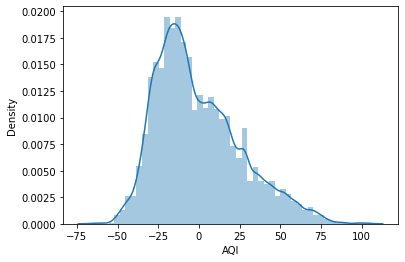

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.distplot(y_validate-y_pred)

### Hyper parameter tuning to improve predictions

#### scale the data

In [124]:
X = process_data_fm(complete_data_set_california, is_test_set=True)
y = complete_data_set_california[["AQI"]]


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


#### cross validation

In [127]:
from sklearn.model_selection import KFold

def Kfold(k,Xs,ys,params_list,learning_rate=0.0001,draw_curve=True):
    # The total number of examples 
    total_num=len(Xs)
    
    # Built in K-fold function in Sci-Kit Learn
    kf=KFold(n_splits=k,shuffle=True)
    # record error for each model
    train_error_all=[]
    test_error_all=[]
    
    for train_selector,test_selector in kf.split(range(total_num)):
        ### Decide training examples and testing examples for this fold ###
        
        train_Xs=Xs[train_selector]
        test_Xs=Xs[test_selector]
        train_ys=ys[train_selector]
        test_ys=ys[test_selector]

        val_array=[]
        # Split training examples further into training and validation
        train_in,val_in,train_real,val_real=train_test_split(train_Xs,train_ys)
        
        
        
        
        # Save the lowest weights, so that we can recover the best model
        lowest_index = -1
        lowest_val_err = np.inf
        
        for i in range(len(params_list)):
            # Train model on different params  and test performance in the validation set
            
            params = params_list[i]

            model = Lasso(alpha=params["alpha"],fit_intercept=params["fit_intercept"],selection=params["selection"])

            model.fit(train_in,train_real)

            val_err = model.evaluate(val_in,val_real)
            val_array.append(val_err)
            if val_err < lowest_val_err:
                lowest_index = i
                lowest_val_err = val_err

        # get back the best model
        best_params = params_list[lowest_index]
        model = Lasso(alpha=best_params["alpha"],fit_intercept=best_params["fit_intercept"],selection=params["selection"])       

        # Report result for this fold
        train_error=model.evaluate(train_Xs, train_ys)
        train_error_all.append(train_error)
        test_error= model.evaluate(test_Xs,test_ys)
        test_error_all.append(test_error)
        print("Train error:",train_error)
        print("Test error:",test_error)
        
        if draw_curve:
            plt.figure()
            plt.plot(np.arange(len(val_array))+1,val_array,label='Validation loss')
            plt.xlabel('i')
            plt.ylabel('Loss')
            plt.legend()
            
    print("Final results:")
    print("Training error:%f+-%f"%(np.average(train_error_all),np.std(train_error_all)))
    print("Testing error:%f+-%f"%(np.average(test_error_all),np.std(test_error_all)))
    
    # return the last model
    return model

param_list = [
    {
        'alpha':.00001,
        'fit_intercept':True,
        'selection':'cyclic',
    },
    {
        'alpha':.0001,
        'fit_intercept':True,
        'selection':'cyclic',
    },
    {
        'alpha':.001,
        'fit_intercept':True,
        'selection':'cyclic',
    },
    {
        'alpha':.01,
        'fit_intercept':True,
        'selection':'cyclic',
    },
    {
        'alpha':.00001,
        'fit_intercept':False,
        'selection':'cyclic',
    },
    {
        'alpha':.0001,
        'fit_intercept':False,
        'selection':'cyclic',
    },
    {
        'alpha':.001,
        'fit_intercept':False,
        'selection':'cyclic',
    },
    {
        'alpha':.01,
        'fit_intercept':False,
        'selection':'cyclic',
    },
    {
        'alpha':.00001,
        'fit_intercept':True,
        'selection':'random',
    },
    {
        'alpha':.0001,
        'fit_intercept':True,
        'selection':'random',
    },
    {
        'alpha':.001,
        'fit_intercept':True,
        'selection':'random',
    },
    {
        'alpha':.01,
        'fit_intercept':True,
        'selection':'random',
    },
        {
        'alpha':.00001,
        'fit_intercept':False,
        'selection':'random',
    },
    {
        'alpha':.0001,
        'fit_intercept':False,
        'selection':'random',
    },
    {
        'alpha':.001,
        'fit_intercept':False,
        'selection':'random',
    },
    {
        'alpha':.01,
        'fit_intercept':False,
        'selection':'random',
    },
]


    

final_model = Kfold(5,X,y,param_list,learning_rate=0.0001)



KeyError: "None of [Index([(1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 26, 28, 29, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 48, 49, 50, 51, 53, 54, 55, 56, 57, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 76, 77, 78, 79, 80, 81, 82, 84, 86, 87, 88, 90, 91, 92, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 106, 107, 109, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120, 121, 123, 125, 126, ...)], dtype='object')] are in the [columns]"